In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score, auc,ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import roc_curve, auc,recall_score,precision_score, f1_score


In [3]:
def plot_roc_curve(y_test, y_prediction):
    fpr, tpr, _ = roc_curve(y_test, y_prediction)
    roc_auc = auc(fpr, tpr)
    plt.figure()

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Data 

In [4]:
#Loading Data
data1=pd.read_csv("transactions_obf.csv")
data2=pd.read_csv("labels_obf.csv")

In [5]:
data1.isnull().sum()

transactionTime          0
eventId                  0
accountNumber            0
merchantId               0
mcc                      0
merchantCountry          0
merchantZip          23005
posEntryMode             0
transactionAmount        0
availableCash            0
dtype: int64

In [6]:
data1.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500


In [7]:
data2.head()

,reportedTime,eventId
0,2017-01-04T00:00:00Z,101536329A1
1,2017-01-04T00:00:00Z,101536425A1
2,2017-01-04T00:00:00Z,101536473A1
3,2017-01-04T00:00:00Z,101536617A1
4,2017-01-04T00:00:00Z,101536761A1


In [8]:
data1.shape

(118621, 10)

In [9]:
data2.shape

(875, 2)

In [10]:
data=data1.copy()

In [11]:
#merging two dataframes to flag fraud transcations 
values = set(data2['eventId'])

data['fraudEvent'] = data['eventId'].isin(values).astype(int)

In [12]:
data['fraudEvent'].value_counts()

0    117746
1       875
Name: fraudEvent, dtype: int64

In [13]:
#Data Dimension
data.shape

(118621, 11)

In [14]:
data.columns

Index(['transactionTime', 'eventId', 'accountNumber', 'merchantId', 'mcc',
       'merchantCountry', 'merchantZip', 'posEntryMode', 'transactionAmount',
       'availableCash', 'fraudEvent'],
      dtype='object')

## Data cleaning and evaluation

In [15]:
#Check for duplicate rows
data.duplicated().sum()

0

In [16]:
data.dtypes.value_counts()

object     5
int64      4
float64    1
int32      1
dtype: int64

In [17]:
data.nunique()

transactionTime      118105
eventId              118621
accountNumber           766
merchantId            33327
mcc                     361
merchantCountry          82
merchantZip            3260
posEntryMode             10
transactionAmount     16431
availableCash            19
fraudEvent                2
dtype: int64

In [18]:
#Check out the object columns, number of uniques and number of NaNs
data.columns[data.isna().any()]

Index(['merchantZip'], dtype='object')

In [19]:
data['merchantZip'].value_counts(dropna=False, normalize=True)*100
#Drop this column 

NaN      19.393699
0        12.201887
E12       0.964416
SL4       0.549650
LS11      0.515086
           ...    
LL59      0.000843
E79HL     0.000843
B54US     0.000843
LE35      0.000843
W84PT     0.000843
Name: merchantZip, Length: 3261, dtype: float64

In [20]:
data.drop('merchantZip', axis=1, inplace=True)

In [21]:
data['transactionTime']=pd.to_datetime(data['transactionTime'])
data['transactionTime'].head()

0   2017-01-01 00:00:00+00:00
1   2017-01-01 00:49:03+00:00
2   2017-01-01 00:43:17+00:00
3   2017-01-01 00:15:07+00:00
4   2017-01-01 00:37:09+00:00
Name: transactionTime, dtype: datetime64[ns, UTC]

In [22]:
#df['transactionTime']
data['year']=pd.DatetimeIndex(data['transactionTime']).year
data['day']=pd.DatetimeIndex(data['transactionTime']).day
data['time']=pd.DatetimeIndex(data['transactionTime']).hour

data['time']

0          0
1          0
2          0
3          0
4          0
          ..
118616    23
118617    23
118618    23
118619     0
118620    23
Name: time, Length: 118621, dtype: int64

In [23]:
df_cat=data.select_dtypes(include=['object'])
df_cat.head()
#Non of categorical columns are useful- no need to encode 

,eventId,accountNumber,merchantId
0,18688431A1,94f9b4e7,b76d06
1,2164986A1,648e19cf,718cc6
2,31294145A1,c0ffab1b,94cafc
3,11162049A1,038099dd,7d5803
4,17067235A1,3130363b,12ca76


In [24]:
#num_attributes=df.select_dtypes(exclude=['object'])
num_attributes=data[['mcc','merchantCountry', 'posEntryMode', 'transactionAmount',
       'availableCash','time','day', 'year']]

describe = num_attributes.describe().T
describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()


describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
mcc,118621.0,5834.407272,976.183515,742.00,5411.00,5691.00,5967.0,9405.0,8663.00,0.167315,0.800649,4.969162
merchantCountry,118621.0,759.124388,154.070084,31.00,826.00,826.00,826.0,840.0,809.00,0.202958,-2.020270,2.687052
posEntryMode,118621.0,28.552651,35.647616,0.00,5.00,5.00,81.0,91.0,91.00,1.248487,0.804020,-1.344966
transactionAmount,118621.0,53.674774,183.665315,-0.15,8.03,20.25,49.0,13348.0,13348.15,3.421818,28.405271,1503.445956
availableCash,118621.0,6625.508974,3410.289486,500.00,4500.00,7500.00,8500.0,18500.0,18000.00,0.514721,-0.182784,-0.541319
time,118621.0,12.026960,6.832199,0.00,6.00,12.00,18.0,23.0,23.00,0.568074,-0.120168,-1.151825
day,118621.0,15.788790,8.717295,1.00,8.00,16.00,23.0,31.0,30.00,0.552119,0.004820,-1.173557
year,118621.0,2017.071918,0.258353,2017.00,2017.00,2017.00,2017.0,2018.0,1.00,0.000128,3.313981,8.982621


In [25]:
from sklearn.preprocessing import RobustScaler
df = data.copy()
df['transactionAmount'] = RobustScaler().fit_transform(df['transactionAmount'].to_numpy().reshape(-1, 1))

In [26]:
num_attributes1=df[['mcc','merchantCountry', 'posEntryMode', 'transactionAmount',
       'availableCash','time','day', 'year']]

describe1 = num_attributes1.describe().T
describe1['range'] = (num_attributes1.max() - num_attributes1.min()).tolist()
describe1['variation coefficient'] = (num_attributes1.std() / num_attributes1.mean()).tolist()
describe1['skew'] = num_attributes1.skew().tolist()
describe1['kurtosis'] = num_attributes1.kurtosis().tolist()


describe1

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
mcc,118621.0,5834.407272,976.183515,742.000000,5411.000000,5691.0,5967.000000,9405.000000,8663.000000,0.167315,0.800649,4.969162
merchantCountry,118621.0,759.124388,154.070084,31.000000,826.000000,826.0,826.000000,840.000000,809.000000,0.202958,-2.020270,2.687052
posEntryMode,118621.0,28.552651,35.647616,0.000000,5.000000,5.0,81.000000,91.000000,91.000000,1.248487,0.804020,-1.344966
transactionAmount,118621.0,0.815835,4.482922,-0.497925,-0.298267,0.0,0.701733,325.305101,325.803027,5.494886,28.405271,1503.445956
availableCash,118621.0,6625.508974,3410.289486,500.000000,4500.000000,7500.0,8500.000000,18500.000000,18000.000000,0.514721,-0.182784,-0.541319
time,118621.0,12.026960,6.832199,0.000000,6.000000,12.0,18.000000,23.000000,23.000000,0.568074,-0.120168,-1.151825
day,118621.0,15.788790,8.717295,1.000000,8.000000,16.0,23.000000,31.000000,30.000000,0.552119,0.004820,-1.173557
year,118621.0,2017.071918,0.258353,2017.000000,2017.000000,2017.0,2017.000000,2018.000000,1.000000,0.000128,3.313981,8.982621


In [27]:
df.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,fraudEvent,year,day,time
0,2017-01-01 00:00:00+00:00,18688431A1,94f9b4e7,b76d06,5968,826,1,-0.232609,7500,0,2017,1,0
1,2017-01-01 00:49:03+00:00,2164986A1,648e19cf,718cc6,5499,826,81,0.022944,4500,0,2017,1,0
2,2017-01-01 00:43:17+00:00,31294145A1,c0ffab1b,94cafc,5735,442,81,-0.371247,9500,0,2017,1,0
3,2017-01-01 00:15:07+00:00,11162049A1,038099dd,7d5803,5499,826,81,0.018306,7500,0,2017,1,0
4,2017-01-01 00:37:09+00:00,17067235A1,3130363b,12ca76,5411,826,81,0.652917,10500,0,2017,1,0


<AxesSubplot:xlabel='fraudEvent', ylabel='count'>

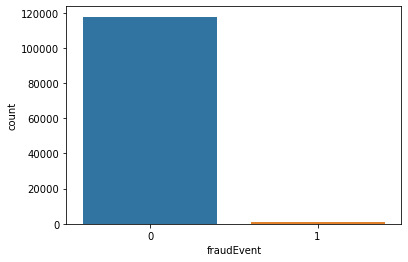

In [28]:
sns.countplot(data=df, x="fraudEvent")

Data is imbalance

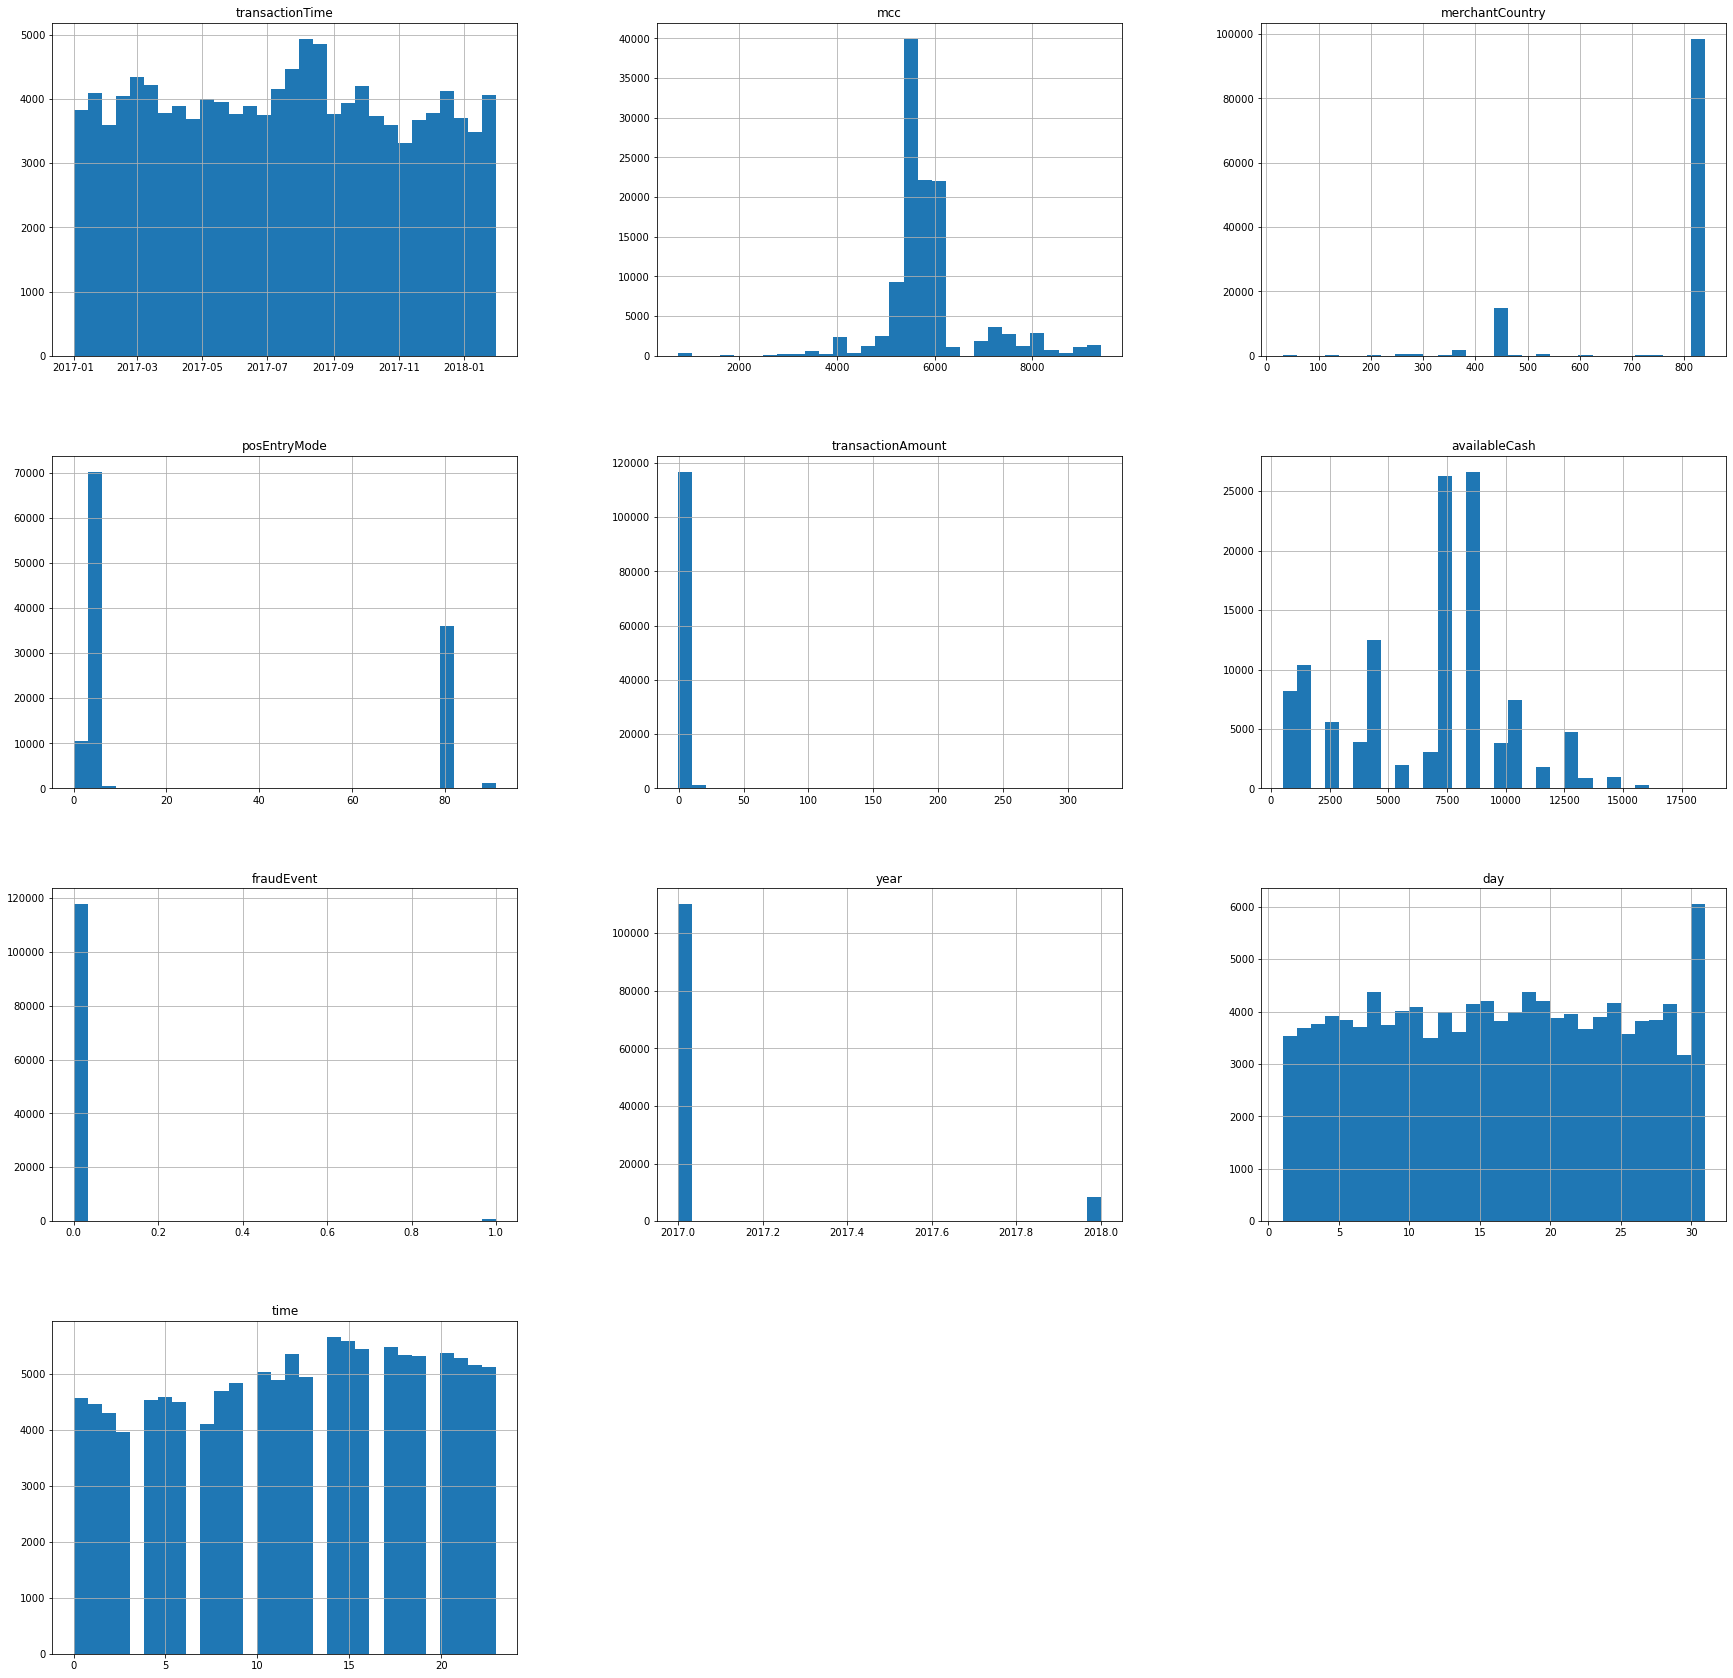

In [29]:
df.hist(bins=30, figsize=(30, 30))
plt.show()

In [30]:
df_f=df[df['fraudEvent']==1]

In [31]:
df_f["accountNumber"].value_counts()


8b9c15ea    97
3ec9dda7    59
6bab7602    48
39219923    45
1602df4e    41
            ..
7158941b     1
94c39106     1
cddc7d2e     1
1c8df5be     1
cf56ce28     1
Name: accountNumber, Length: 167, dtype: int64

In [32]:
test=df[df["accountNumber"]=="8b9c15ea"]


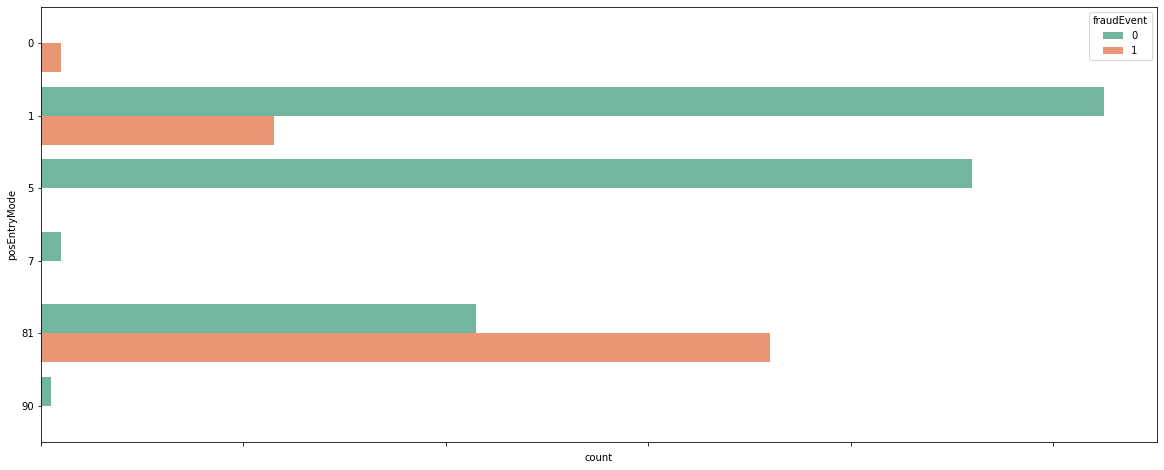

In [33]:
plt.figure(figsize=(20,8))
chart=sns.countplot(y='posEntryMode', data=test, hue='fraudEvent',palette='Set2') 
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
plt.show()

plt.figure(figsize=(20,25))
chart=sns.countplot(y='merchantId', data=test, hue='fraudEvent',palette='Set2') 
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
plt.show()

In [34]:
df_f.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,fraudEvent,year,day,time
14,2017-01-01 03:53:34+00:00,85602730A1,645c318d,66f14e,5541,36,5,-0.226995,1500,1,2017,1,3
740,2017-01-03 13:15:07+00:00,101536761A1,f42ba1f1,5f7cd4,5968,840,81,-0.053454,1500,1,2017,3,13
741,2017-01-03 13:27:22+00:00,101536857A1,f42ba1f1,aebafc,4814,826,1,-0.225775,1500,1,2017,3,13
743,2017-01-03 13:27:02+00:00,101536329A1,f42ba1f1,aebafc,4814,826,1,-0.274591,1500,1,2017,3,13
744,2017-01-03 13:38:15+00:00,101536953A1,f42ba1f1,7e57ae,4816,840,81,-0.494264,1500,1,2017,3,13


In [35]:
df_f["merchantId"].value_counts()

4fd0ff    49
2be1cd    48
707b6c    19
6a5933    17
e57467    14
          ..
2c3fc4     1
cb180a     1
45d79b     1
da5585     1
1a0510     1
Name: merchantId, Length: 438, dtype: int64

In [36]:
df["merchantId"].value_counts()

96878e    3294
243074    2281
7f7cdb    1784
4fd0ff    1554
7c3a49    1143
          ... 
9e60e2       1
309150       1
d95c39       1
261643       1
506a9b       1
Name: merchantId, Length: 33327, dtype: int64

In [37]:
df["merchantCountry"].value_counts()


826    95616
442    14929
840     2873
372     1414
250      483
       ...  
703        1
48         1
566        1
410        1
32         1
Name: merchantCountry, Length: 82, dtype: int64

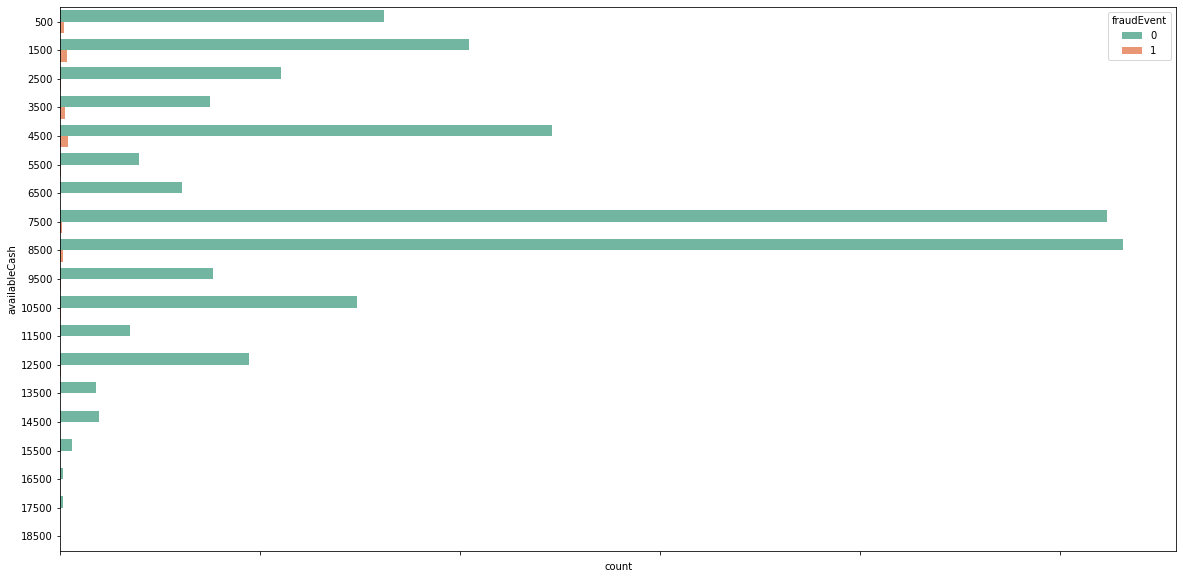

In [38]:
plt.figure(figsize=(20,10))
chart=sns.countplot(y='availableCash', data=df, hue='fraudEvent',palette='Set2') 
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
plt.show()

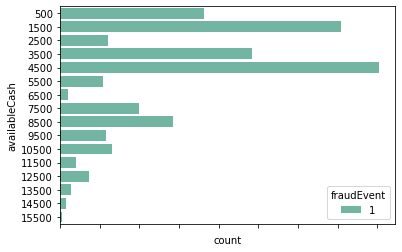

In [39]:
#plt.figure(figsize=(20,10))
chart=sns.countplot(y='availableCash', data=df_f, hue='fraudEvent',palette='Set2') 
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
plt.show()

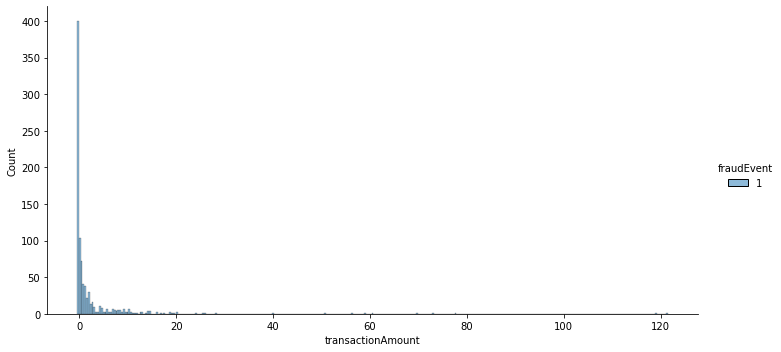

In [40]:
sns.displot(x='transactionAmount', data=df_f, hue='fraudEvent', aspect=2)
plt.show()

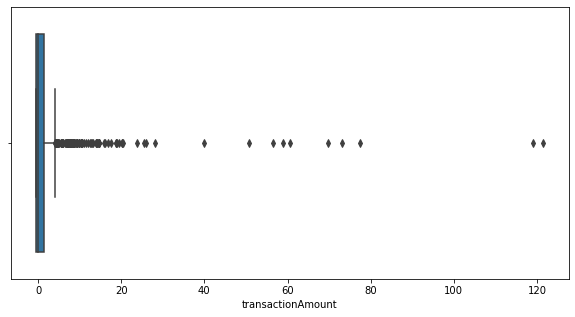

In [41]:
# Outliers
plt.figure(figsize=(10,5))
sns.boxplot(data=df_f, x='transactionAmount')

plt.show()

<Figure size 1080x540 with 0 Axes>

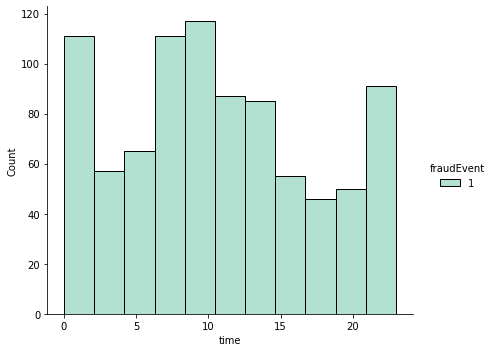

In [42]:
plt.figure(figsize=(12,6), dpi=90)
sns.displot(x='time', data=df_f, hue='fraudEvent',palette='Set2', aspect=1.2)
plt.show()

<Figure size 1080x540 with 0 Axes>

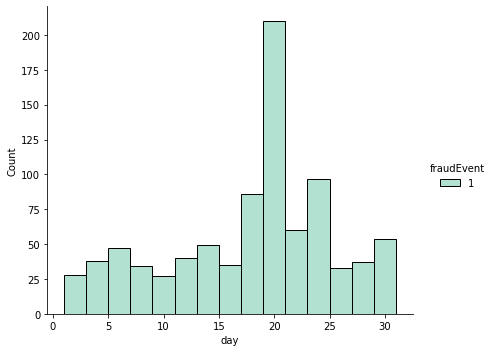

In [43]:
plt.figure(figsize=(12,6), dpi=90)
sns.displot(x='day', data=df_f, hue='fraudEvent',palette='Set2', aspect=1.2)
plt.show()

<Figure size 1080x540 with 0 Axes>

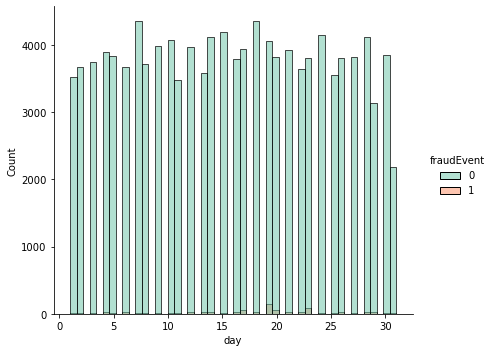

In [44]:
plt.figure(figsize=(12,6), dpi=90)
sns.displot(x='day', data=df, hue='fraudEvent',palette='Set2', aspect=1.2)
plt.show()

<Figure size 1080x540 with 0 Axes>

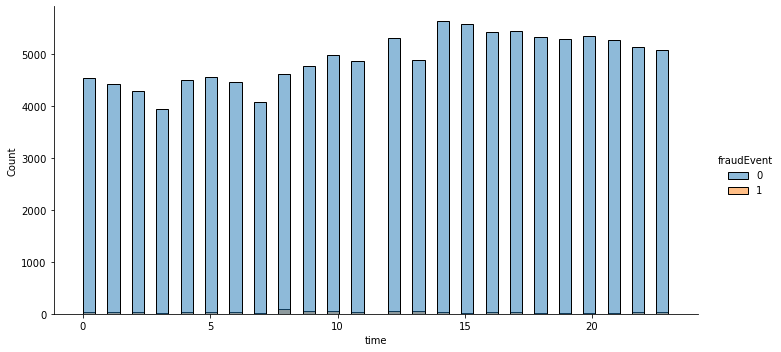

In [45]:
plt.figure(figsize=(12,6), dpi=90)
sns.displot(x='time', data=df, hue='fraudEvent', aspect=2)
plt.show()

In [46]:
list_fe=df[df["fraudEvent"]==1]["posEntryMode"].value_counts()
list_nfe= df[df["fraudEvent"]==0]["posEntryMode"].value_counts()
print(list_fe, list_nfe)

81    630
1     210
5      18
90     13
0       2
2       2
Name: posEntryMode, dtype: int64 5     70210
81    35202
1     10358
90     1189
7       637
80       92
79       31
2        14
0         9
91        4
Name: posEntryMode, dtype: int64


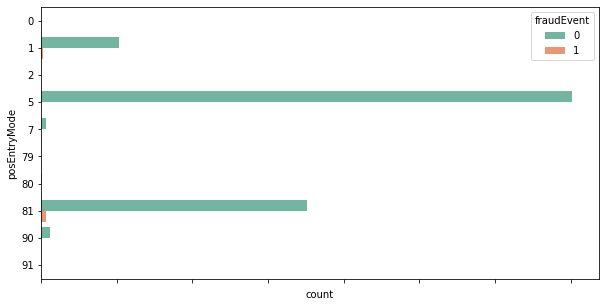

In [47]:
plt.figure(figsize=(10,5))
chart=sns.countplot(y='posEntryMode', data=df, hue='fraudEvent',palette='Set2') 
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
plt.show()

<AxesSubplot:xlabel='posEntryMode', ylabel='transactionAmount'>

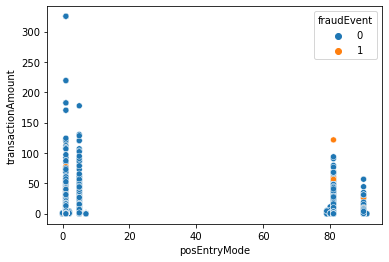

In [48]:
sns.scatterplot(data=df, y="transactionAmount", x="posEntryMode", hue='fraudEvent')


<AxesSubplot:xlabel='availableCash', ylabel='transactionAmount'>

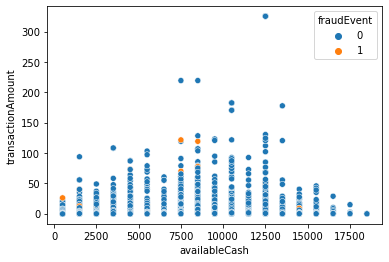

In [49]:
sns.scatterplot(data=df, y="transactionAmount", x="availableCash", hue='fraudEvent')


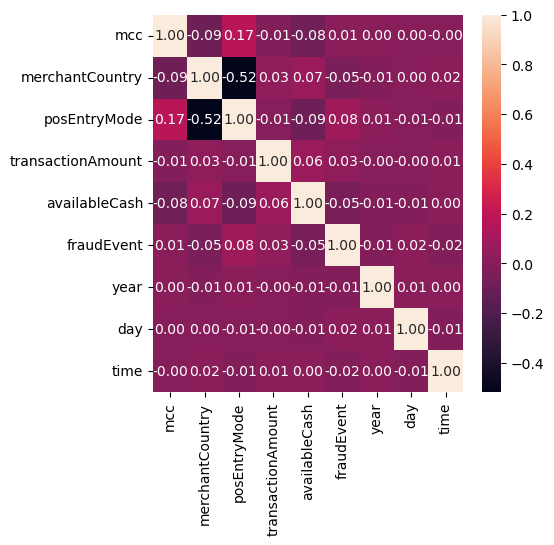

In [50]:
plt.figure(figsize=(5,5), dpi=100)
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

In [51]:
df.columns

Index(['transactionTime', 'eventId', 'accountNumber', 'merchantId', 'mcc',
       'merchantCountry', 'posEntryMode', 'transactionAmount', 'availableCash',
       'fraudEvent', 'year', 'day', 'time'],
      dtype='object')

In [52]:
df_final=df[['mcc','merchantCountry', 'posEntryMode', 'transactionAmount',
       'availableCash', 'fraudEvent']]

In [53]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118621 entries, 0 to 118620
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   mcc                118621 non-null  int64  
 1   merchantCountry    118621 non-null  int64  
 2   posEntryMode       118621 non-null  int64  
 3   transactionAmount  118621 non-null  float64
 4   availableCash      118621 non-null  int64  
 5   fraudEvent         118621 non-null  int32  
dtypes: float64(1), int32(1), int64(4)
memory usage: 5.0 MB


In [54]:
# separating X and y variables
X =df_final.drop("fraudEvent", axis=1)
y = df_final.loc[:,"fraudEvent"].values.ravel()

### ExtraTreesClassifier for feature importance

In [55]:
m=ExtraTreesClassifier()
m.fit(X,y)

ExtraTreesClassifier()

In [56]:
# imp_featrs= pd.Series(m.feature_importances_, index=X.columns)
# imp_featrs.nlargest(10).plot(kind='barh')
# plt.show()

In [57]:
#Sampling
random_stat=20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=20)

In [58]:
# print("training data :", y_train[y_train['fraudEvent']==1],y_train[y_train['fraudEvent']==0])
# print("testing data :",y_test[y_test['fraudEvent']==1], y_test[y_test['fraudEvent']==0])



# Random Forest 

In [59]:
rf = RandomForestClassifier(max_depth=2,class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=2)

In [60]:
print(rf.score(X_train, y_train)) # train accu
print(rf.score(X_test, y_test)) # test accu

0.8509420839656044
0.8504952581664911


In [61]:
rf_predictions = rf.predict(X_test)

In [62]:
# Evaluation 
cm = confusion_matrix(y_test, rf_predictions)
cr = classification_report(y_test, rf_predictions)
print(cm,"\n")
print(cr)


[[20057  3501]
 [   46   121]] 

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     23558
           1       0.03      0.72      0.06       167

    accuracy                           0.85     23725
   macro avg       0.52      0.79      0.49     23725
weighted avg       0.99      0.85      0.91     23725



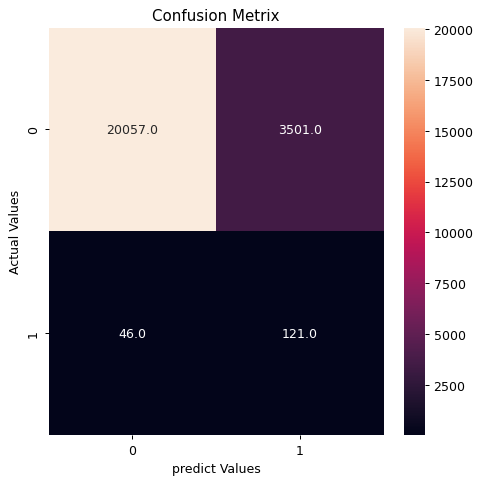

In [63]:
# plotting confusion metrix
plt.figure(figsize=(6,6), dpi=90)
sns.heatmap(cm, annot=True, fmt=".1f")
plt.title("Confusion Metrix")
plt.ylabel("Actual Values")
plt.xlabel("predict Values")
plt.show()

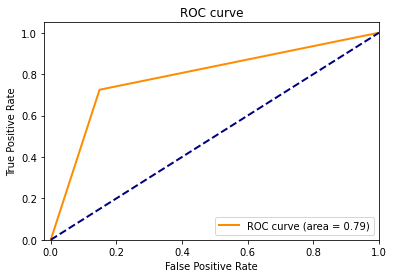

In [64]:
plot_roc_curve(y_test, rf_predictions)

# XG Boost

In [65]:
df_final['fraudEvent'].value_counts()[0]/df_final['fraudEvent'].value_counts()[1]

134.56685714285715

In [66]:
xgb = XGBClassifier(eta=0.05, gamma=2,learning_rate=0.05, scale_pos_weight=135,  eval_metric='mlogloss')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.05, eval_metric='mlogloss', gamma=2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=135,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [67]:
print(xgb.score(X_train, y_train)) # train accu
print(xgb.score(X_test, y_test)) # test accu

0.8957384926656551
0.893277133825079


In [68]:
xgb_predictions = xgb.predict(X_test)
print(y_test,xgb_predictions)

[0 0 0 ... 0 0 0] [0 0 0 ... 0 0 0]


In [69]:
# Evaluation 
xgb_cm = confusion_matrix(y_test, xgb_predictions)
xgb_cr = classification_report(y_test, xgb_predictions)
print(xgb_cm,"\n")
print(xgb_cr)

[[21045  2513]
 [   19   148]] 

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     23558
           1       0.06      0.89      0.10       167

    accuracy                           0.89     23725
   macro avg       0.53      0.89      0.52     23725
weighted avg       0.99      0.89      0.94     23725



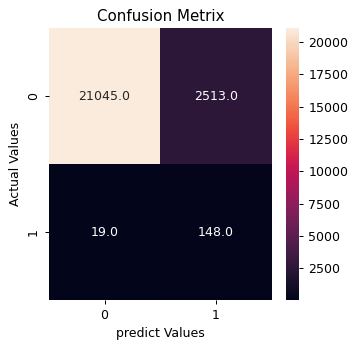

In [70]:
# plotting confusion metrix
plt.figure(figsize=(4,4), dpi=90)
sns.heatmap(xgb_cm, annot=True, fmt=".1f")
plt.title("Confusion Metrix")
plt.ylabel("Actual Values")
plt.xlabel("predict Values")
plt.show()

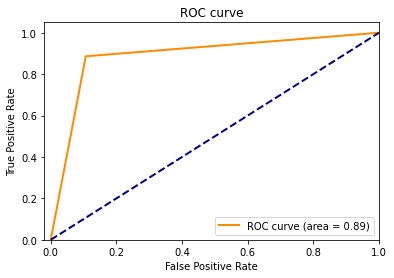

In [71]:
plot_roc_curve(y_test, xgb_predictions)

In [72]:
# #Cross Validation
# score=cross_val_score(xgb,X,y,cv=10)
# score

In [73]:
#Cross Validation
# score=cross_val_score(rf,X,y,cv=10)
# score

# IsolationForest

In [74]:
fraud=df_final[df_final['fraudEvent']==1]
valid=df_final[df_final['fraudEvent']==0]
outlier_fraction = len(fraud)/float(len(valid))
outlier_fraction

0.007431250318482157

In [75]:
isoFor=IsolationForest(n_estimators=70, max_samples='auto', contamination=float(0.1),max_features=1.0, n_jobs=2)
isoFor.fit(X_train)

IsolationForest(contamination=0.1, n_estimators=70, n_jobs=2)

In [76]:
df1=X_test.copy()
df1['score']=isoFor.decision_function(X_test)

df1['anomaly']=isoFor.predict(X_test)
df1.head()

,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,score,anomaly
98059,5969,442,81,0.091530,7500,0.101128,1
48317,5942,442,81,0.114230,4500,0.084750,1
105638,5411,826,81,-0.421040,12500,0.064513,1
100628,5541,826,5,1.579204,7500,0.166139,1
59046,5735,442,81,-0.295338,3500,0.078427,1


In [77]:
df1[['score','anomaly']].head()

,score,anomaly
98059,0.101128,1
48317,0.084750,1
105638,0.064513,1
100628,0.166139,1
59046,0.078427,1


In [78]:
y_pred = df1['anomaly'].copy()

y_pred.values[y_pred.values == 1]=0
y_pred.values[y_pred.values == -1]=1


In [79]:
iso_cmb=confusion_matrix(y_test, y_pred)

In [80]:
# Evaluation 
iso_cmb = confusion_matrix(y_test, y_pred)
iso_crb = classification_report(y_test, y_pred)
print(iso_cmb,"\n")
print(iso_crb)



[[21104  2454]
 [  102    65]] 

              precision    recall  f1-score   support

           0       1.00      0.90      0.94     23558
           1       0.03      0.39      0.05       167

    accuracy                           0.89     23725
   macro avg       0.51      0.64      0.50     23725
weighted avg       0.99      0.89      0.94     23725



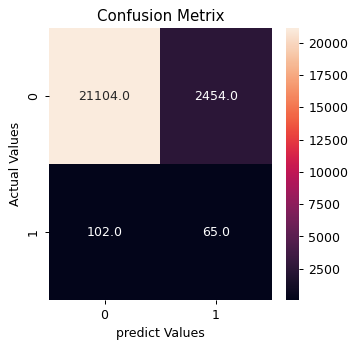

In [81]:
# plotting confusion metrix
plt.figure(figsize=(4,4), dpi=90)
sns.heatmap(iso_cmb, annot=True, fmt=".1f")
plt.title("Confusion Metrix")
plt.ylabel("Actual Values")
plt.xlabel("predict Values")
plt.show()

# Balanced data set

In [82]:
not_frauds = df_final.query('fraudEvent == 0')
frauds = df_final.query('fraudEvent == 1')
not_frauds['fraudEvent'].value_counts(), frauds['fraudEvent'].value_counts()

(0    117746
 Name: fraudEvent, dtype: int64,
 1    875
 Name: fraudEvent, dtype: int64)

In [83]:
balanced_df = pd.concat([frauds, not_frauds.sample(len(frauds), random_state=20)])
balanced_df['fraudEvent'].value_counts()

1    875
0    875
Name: fraudEvent, dtype: int64

In [84]:
balanced_df = balanced_df.sample(frac=1, random_state=1)
balanced_df.head(3)

,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,fraudEvent
37865,5411,826,5,0.632902,7500,0
70712,4814,826,1,-0.445448,7500,0
15051,5735,442,81,-0.284598,1500,1


In [85]:
# separating X and y variables
X_b =balanced_df.drop("fraudEvent", axis=1)
y_b = balanced_df.loc[:,"fraudEvent"].values.ravel()

In [86]:
#Sampling
random_stat=20
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_b, y_b, test_size = 0.2, random_state=20)

## Random Forest - balanced data set

In [87]:
rf_b= RandomForestClassifier(max_depth=2,class_weight="balanced")
rf_b.fit(Xb_train, yb_train)
print(rf_b.score(Xb_train, yb_train)) # train accu
print(rf_b.score(Xb_test, yb_test))  #test accu


0.7878571428571428
0.8


In [88]:
rf_b_predictions = rf_b.predict(Xb_test)

In [89]:
# Evaluation 
cmb = confusion_matrix(yb_test, rf_b_predictions)
crb = classification_report(yb_test, rf_b_predictions)
print(cmb,"\n")
print(crb)


[[167  31]
 [ 39 113]] 

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       198
           1       0.78      0.74      0.76       152

    accuracy                           0.80       350
   macro avg       0.80      0.79      0.80       350
weighted avg       0.80      0.80      0.80       350



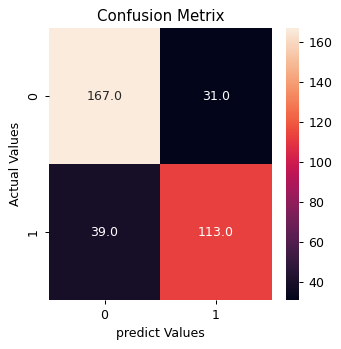

In [90]:
# plotting confusion metrix
plt.figure(figsize=(4,4), dpi=90)
sns.heatmap(cmb, annot=True, fmt=".1f")
plt.title("Confusion Metrix")
plt.ylabel("Actual Values")
plt.xlabel("predict Values")
plt.show()

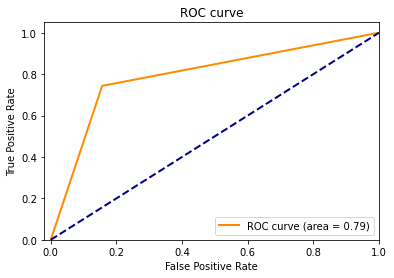

In [91]:
plot_roc_curve(yb_test, rf_b_predictions)

## XG Boost - balanced data set

In [92]:
xgb_b = XGBClassifier (gamma=2,learning_rate=0.01, eta=0.5,  eval_metric='mlogloss', max_depth=3)
xgb_b.fit(Xb_train, yb_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.5, eval_metric='mlogloss', gamma=2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [93]:
print(xgb_b.score(Xb_train, yb_train)) # train accu
print(xgb_b.score(Xb_test, yb_test)) # test accu



0.8378571428571429
0.8142857142857143


In [94]:
xgb_b_predictions = xgb_b.predict(Xb_test)
#print(yb_test,xgb_b_predictions)

In [95]:
# Evaluation 
xgb_b_cm = confusion_matrix(yb_test, xgb_b_predictions)
xgb_b_cr = classification_report(yb_test, xgb_b_predictions)
print(xgb_b_cm,"\n")
print(xgb_b_cr)


[[155  43]
 [ 22 130]] 

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       198
           1       0.75      0.86      0.80       152

    accuracy                           0.81       350
   macro avg       0.81      0.82      0.81       350
weighted avg       0.82      0.81      0.82       350



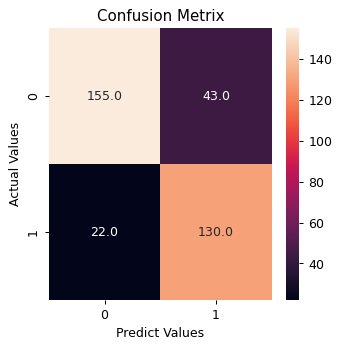

In [96]:
# plotting confusion metrix
plt.figure(figsize=(4,4), dpi=90)
sns.heatmap(xgb_b_cm, annot=True, fmt=".1f")
plt.title("Confusion Metrix")
plt.ylabel("Actual Values")
plt.xlabel("Predict Values")
plt.show()

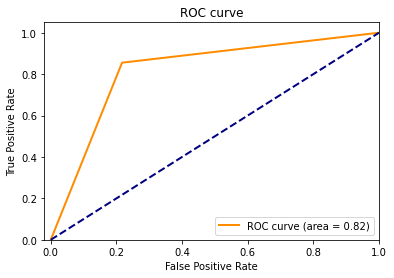

In [97]:
plot_roc_curve(yb_test, xgb_b_predictions)

In [98]:
#Cross Validation
score=cross_val_score(xgb_b,X_b,y_b,cv=10)
score

array([0.84      , 0.81142857, 0.85142857, 0.82857143, 0.80571429,
       0.81142857, 0.83428571, 0.81142857, 0.81142857, 0.86285714])